In [33]:
import sys
import h5py

sys.path.append('../../makiper/BaselineModels/XGBoost')
from xgb import make_xgb_model

sys.path.append('../../makiper/BaselineModels/ResNet')
from ResNet import make_model

sys.path.append('../../run')
from model import SimpleSeqClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from tqdm import tqdm

import matplotlib.pyplot as plt

In [34]:
datasets = ['/scratch/jakelee/emit-cloud/cloud_datasets/lbox_1e4_v6.hdf5', '/scratch/jakelee/emit-cloud/cloud_datasets/mmgis_1e4_v6.hdf5']

for i, dataset in enumerate(datasets):
    if i == 0:
        f = h5py.File(dataset, 'r')
        labels = f['labels'][:]
        fids = f['fids'][:]
        spectra = f['spectra'][:]
        bands = f.attrs['bands']
    else:
        f = h5py.File(dataset, 'r')
        labels = np.concatenate((labels, f['labels'][:]))
        fids = np.concatenate((fids, f['fids'][:]))
        spectra = np.concatenate((spectra, f['spectra'][:]))

device = torch.device("cpu")

with open('../v6_test.csv', 'r') as f:
    test_fids = [line.strip() for line in f.readlines()]
    test_fids = set(test_fids)
# Only keep indices of fids that are in the test set
test_i = [i for i, f in enumerate(fids) if f.decode('utf-8') in test_fids]

test_X = spectra[test_i]
test_y = labels[test_i]
test_y[test_y==2] = 0

              precision    recall  f1-score   support

           0      0.936     0.962     0.949    249648
           1      0.961     0.934     0.947    246863

    accuracy                          0.948    496511
   macro avg      0.949     0.948     0.948    496511
weighted avg      0.948     0.948     0.948    496511

ROC AUC: 0.9867198948884356
(3, 51914)


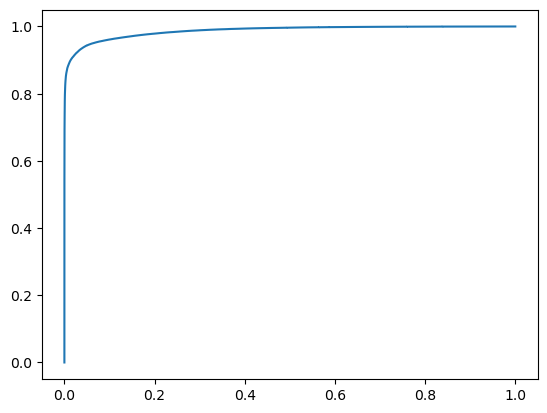

In [39]:
# XGBOOST

model = make_xgb_model(
    arch_yml = '/home/jakelee/cloud/emit-cloud-screening/makiper/BaselineModels/XGBoost/20241016/xgboost_arch_165.yml', 
    arch_subkeys = ["architecture"], # optional - tells the function where to start parsing the yaml file
    weight_file = '/home/jakelee/cloud/emit-cloud-screening/makiper/BaselineModels/XGBoost/20241016/XGBoost-165-take1e4_v6_2024_10_15_21_03.json' # optional- loads in this xgboost model
)

pred_y = model.predict_proba(test_X)

pred_y_binary = pred_y[:,1] >= 0.96

print(classification_report(test_y, pred_y_binary, digits=3))

print("ROC AUC:", roc_auc_score(test_y, pred_y[:,1]))

xgboost_auc = roc_curve(test_y, pred_y[:,1], pos_label=1)
xgboost_auc = np.array(xgboost_auc)
print(xgboost_auc.shape)
plt.plot(xgboost_auc[0,:], xgboost_auc[1,:])
np.save('xgboost_auc.npy', xgboost_auc)

100%|██████████| 485/485 [00:27<00:00, 17.48it/s]


(496511,) (496511,)
              precision    recall  f1-score   support

           0      0.945     0.971     0.958    249648
           1      0.969     0.943     0.956    246863

    accuracy                          0.957    496511
   macro avg      0.957     0.957     0.957    496511
weighted avg      0.957     0.957     0.957    496511

ROC AUC: 0.9863013153963321


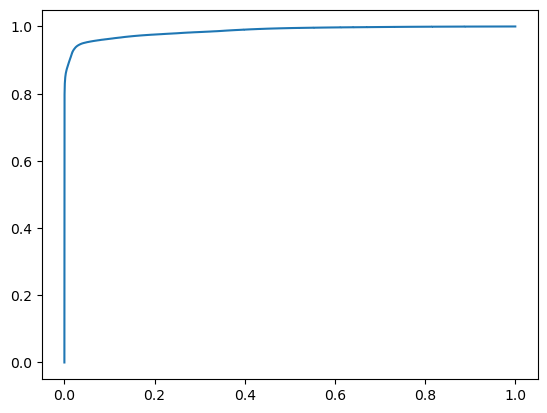

In [41]:
# ANN

model = make_model(
    arch_yml='/home/jakelee/cloud/emit-cloud-screening/makiper/BaselineModels/ResNet/20241016/resnet_arch_-P-1400-L-1.yml',
    input_dim=268,
    num_classes=2,
    arch_subkeys=['architecture'], # this is optional - tells the funtion where to start parsing the yaml file
    weight_file='/home/jakelee/cloud/emit-cloud-screening/makiper/BaselineModels/ResNet/20241016/ResNet-P-1400-L-1-2lk54l0k-take1e4_v6_2024_10_16_04_03.pt' # this is optional
)

class SpectraDataset(Dataset):
    """Pixelwise spectra dataset."""

    def __init__(self, spectra, labels, transform=None, device='cpu'):
        super().__init__()
        self.spectra = torch.tensor(spectra, dtype=torch.float32).to(device)

        self.labels = torch.tensor(labels).to(device)
        self.labels[self.labels==2] = 0 # shadow considered clear

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        out_spec = self.spectra[idx]
        if self.transform is not None:
            out_spec = self.transform(out_spec)
        
        return {
            'spectra': torch.unsqueeze(out_spec, -1),
            'label': self.labels[idx]
        }

test_dataset = SpectraDataset(test_X, test_y, transform=None, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

pred_y = []
for idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
    spectra = batch['spectra'].to(device)
    spectra = spectra[:,:,0]

    with torch.no_grad():
        pred = model(spectra)
        proba = nn.functional.softmax(pred, dim=1)
        pred_y += proba[:,1].cpu().detach().numpy().tolist()

pred_y = np.array(pred_y)
pred_y_binary = pred_y >= 0.98

print(pred_y_binary.shape, test_y.shape)

print(classification_report(test_y, pred_y_binary, digits=3))

print("ROC AUC:", roc_auc_score(test_y, pred_y))

ann_auc = roc_curve(test_y, pred_y, pos_label=1)
ann_auc = np.array(ann_auc)
plt.plot(ann_auc[0,:], ann_auc[1,:])
np.save('ann_auc.npy', ann_auc)

100%|██████████| 485/485 [06:19<00:00,  1.28it/s]


(496511,) (496511,)
              precision    recall  f1-score   support

           0      0.945     0.962     0.953    249648
           1      0.960     0.944     0.952    246863

    accuracy                          0.953    496511
   macro avg      0.953     0.953     0.953    496511
weighted avg      0.953     0.953     0.953    496511

ROC AUC: 0.9847948220797025


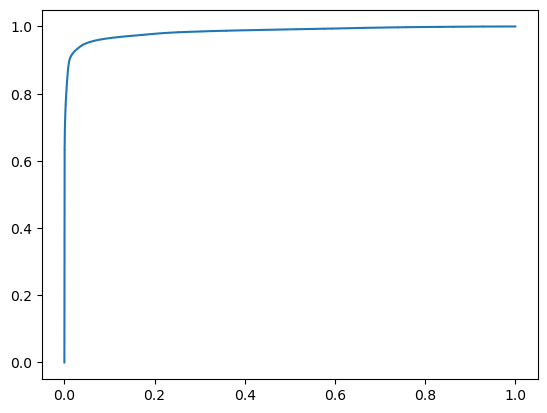

In [42]:
# SpecTF
banddef = torch.tensor(bands, dtype=torch.float32).to(device)
model = SimpleSeqClassifier(banddef,
                            num_classes=2,
                            num_heads=8,
                            dim_proj=64,
                            dim_ff=64,
                            dropout=0).to(device)
model.load_state_dict(torch.load('/home/jakelee/cloud/models/v6_m4.pt', map_location=device))

test_dataset = SpectraDataset(test_X, test_y, transform=None, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

pred_y = []
for idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
    spectra = batch['spectra'].to(device)

    with torch.no_grad():
        pred = model(spectra)
        proba = nn.functional.softmax(pred, dim=1)
        pred_y += proba[:,1].cpu().detach().numpy().tolist()

pred_y = np.array(pred_y)
pred_y_binary = pred_y >= 0.52

print(pred_y_binary.shape, test_y.shape)

print(classification_report(test_y, pred_y_binary, digits=3))

print("ROC AUC:", roc_auc_score(test_y, pred_y))

tf_auc = roc_curve(test_y, pred_y, pos_label=1)
tf_auc = np.array(tf_auc)
plt.plot(tf_auc[0,:], tf_auc[1,:])
np.save('tf_auc.npy', tf_auc)